In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.distributions import Uniform
# from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, OneCycleLR

import pytorch_lightning as pl
from pytorch_lightning import Trainer
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

import torchmetrics

import numpy as np
import matplotlib.pyplot as plt

import wandb

import pandas as pd

PATH_DATASETS = "."
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 512 if AVAIL_GPUS else 64
# BATCH_SIZE=1

In [2]:
pl.seed_everything(125)

Global seed set to 125


125

## Generate Data

In [3]:
def h1(x):
    return torch.sign(x[:,0]+2)

def h2(x):
    return torch.sign(x[:,0]+1)

def h3(x):
    return torch.sign(x[:,0]-1)

def h4(x):
    return torch.sign(x[:,0]-2)

def h5(x):
    return torch.sign(x[:,1]+1)

def h6(x):
    return torch.sign(x[:,1]-1)

def h7(x):
    return torch.sign(x[:,1]-2)

In [ ]:
def AND(x, *hs):
    return torch.all([])

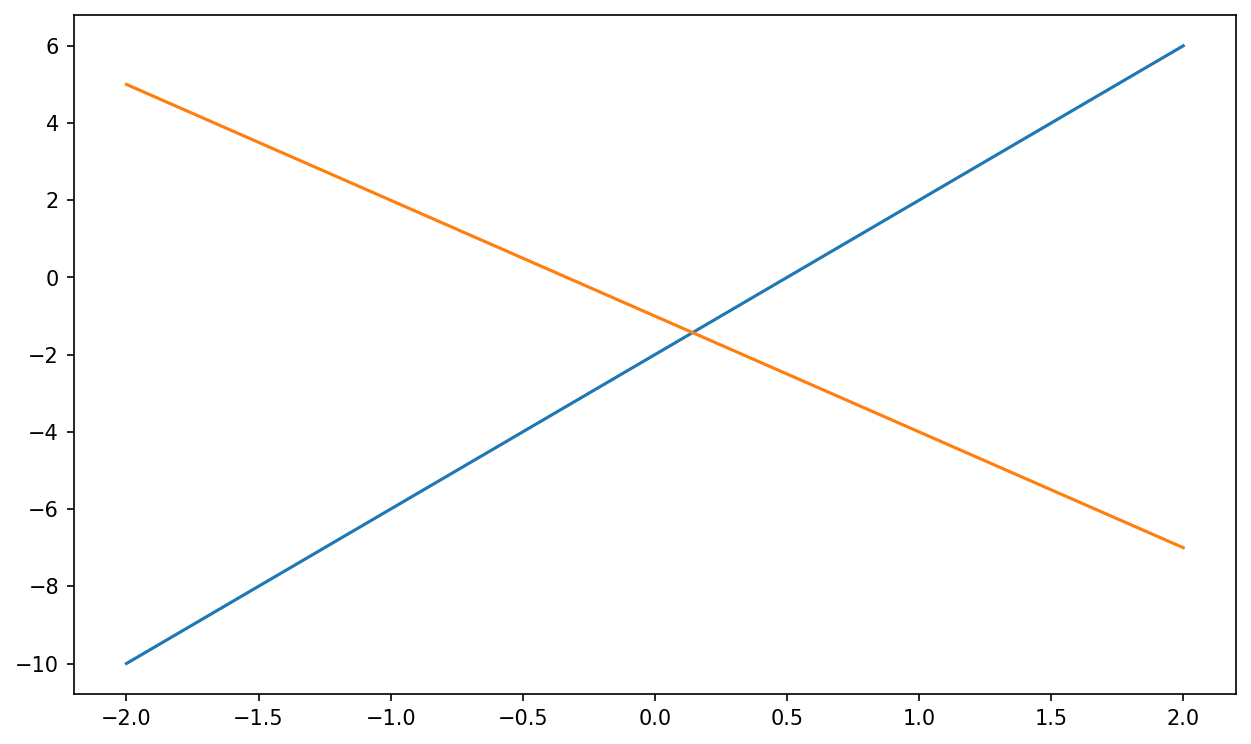

In [4]:
x = np.linspace(-2, 2, 100)

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, f1(x))
plt.plot(x, f2(x))
plt.show()

In [5]:
def calc_group(x, y):
    h1 = f1(x) - y
    h2 = y - f2(x)
    return torch.sign(h1) * torch.sign(h2) / 2 + 0.5

In [6]:
calc_group(torch.tensor(1.0), torch.tensor(-10.0))

tensor(0.)

In [7]:
class MLPData(Dataset):
    def __init__(self, x, y, g):
        self.X = torch.column_stack([x, y])
        self.g = g
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.g[idx]

In [8]:
def gen_data(N):
    u_x = Uniform(-2, 2)
    u_y = Uniform(-10, 6)
    
    x = u_x.sample((N,))
    y = u_y.sample((N,))
    g = calc_group(x, y)
    
    return MLPData(x, y, g)

In [9]:
ds = gen_data(100)

In [10]:
X, g = ds[:]

In [11]:
df = pd.DataFrame({
    'x': X[:,0],
    'y': X[:,1],
    'g': g
})

In [12]:
df

,x,y,g
0,0.887435,5.026489,0.0
1,-0.458459,0.243862,1.0
2,0.911431,-8.664517,0.0
3,-1.581095,3.102341,1.0
4,0.641906,-7.020555,0.0
...,...,...,...
95,-1.553315,3.978768,0.0
96,1.813842,-6.739335,0.0
97,-1.161629,-4.660318,1.0
98,1.435614,2.719082,1.0


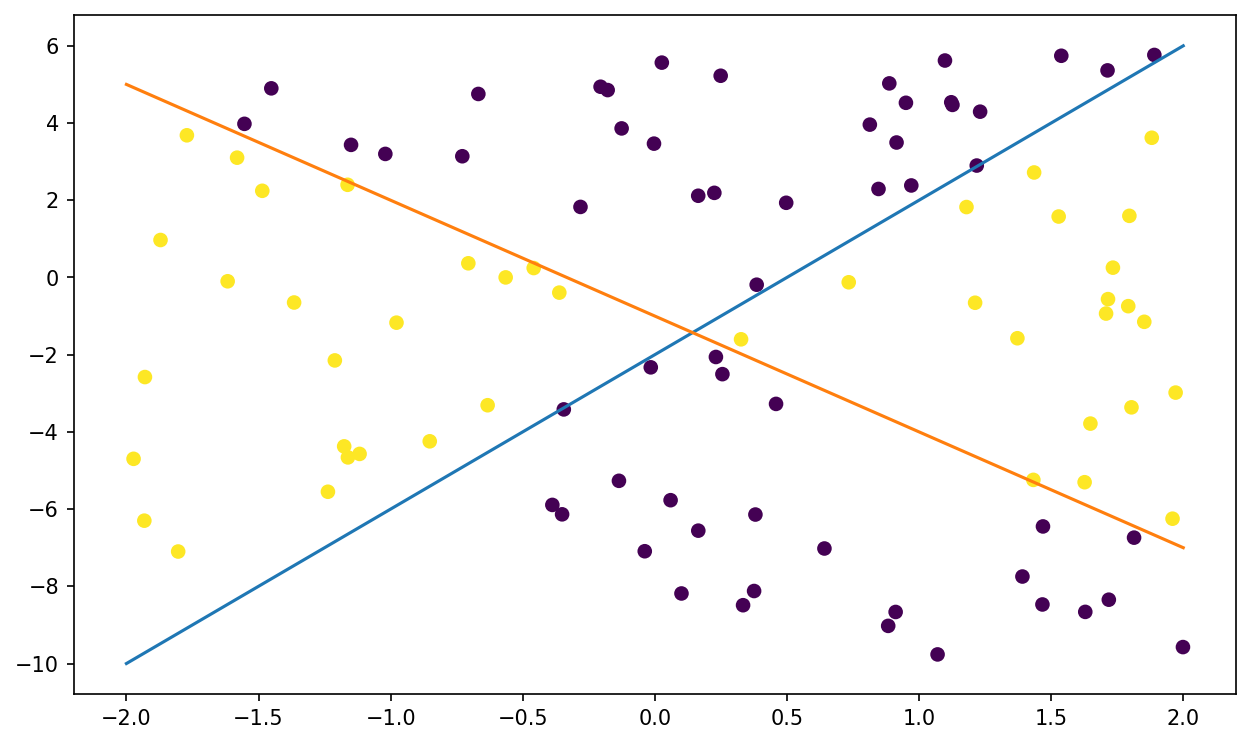

In [13]:
plt.figure(figsize=(10, 6), dpi=150)
plt.scatter(x='x', y='y', c='g', data=df)
plt.plot(x, f1(x))
plt.plot(x, f2(x))
plt.show()

## Network Setup

In [14]:
class SimpleMLP(pl.LightningModule):
    def __init__(self, N=10000, hparams=None):
        super().__init__()
        
        self.N = N
        
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.05),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.05),
            nn.Linear(64, 1),
        )
        
        self.learning_rate = hparams['learning_rate']
        self.batch_size = hparams['batch_size']
        self.epochs = hparams['epochs']
        self.accuracy = torchmetrics.Accuracy()
        
        self.save_hyperparameters(hparams)
        
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        X, g = batch # X: (Batch, 2), g: (Batch, 1)
        
        g_hat = self(X)
        g = g.reshape(-1, 1)
        
        loss = F.binary_cross_entropy_with_logits(g_hat, g)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, g = batch
        
        g_hat = self(X)
        g = g.reshape(-1, 1)
        
        loss = F.binary_cross_entropy_with_logits(g_hat, g)
        acc = self.accuracy(torch.round(torch.sigmoid(g_hat)), g.int())
        
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        
        return loss
    
    def configure_optimizers(self):
#         optimizer = optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def prepare_data(self):
        self.ds = gen_data(self.N)
        
    def setup(self, stage=None):
        N_train = self.N // 10 * 7
        N_val = self.N - N_train
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [N_train, N_val])
        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds, [N_train, N_val])
            
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

In [15]:
hparams = {
    "learning_rate": 1e-4,
    "batch_size": BATCH_SIZE,
    "epochs": 200
}

model = SimpleMLP(
    hparams=hparams
)

wandb_logger = WandbLogger(
    project='LFD_Chap7'
)

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=hparams["epochs"],
    gpus=AVAIL_GPUS,
    enable_progress_bar=False,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [16]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: axect (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name     | Type       | Params
----------------------------------------
0 | net      | Sequential | 4.7 K 
1 | accuracy | Accuracy   | 0     
----------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
/home/xteca/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 125
/home/xteca/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the 

In [17]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▃▄▅▆▆▇▇▇▇▇█████████████████████████████
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
trainer/global_step,2799
val_acc,0.99467
val_loss,0.04884


In [18]:
df

,x,y,g
0,0.887435,5.026489,0.0
1,-0.458459,0.243862,1.0
2,0.911431,-8.664517,0.0
3,-1.581095,3.102341,1.0
4,0.641906,-7.020555,0.0
...,...,...,...
95,-1.553315,3.978768,0.0
96,1.813842,-6.739335,0.0
97,-1.161629,-4.660318,1.0
98,1.435614,2.719082,1.0


In [19]:
g_hat = F.sigmoid(model(X))

/home/xteca/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [20]:
df["g_hat"] = g_hat.detach().numpy()

In [21]:
df

,x,y,g,g_hat
0,0.887435,5.026489,0.0,0.001079
1,-0.458459,0.243862,1.0,0.905656
2,0.911431,-8.664517,0.0,0.000078
3,-1.581095,3.102341,1.0,0.995510
4,0.641906,-7.020555,0.0,0.000026
...,...,...,...,...
95,-1.553315,3.978768,0.0,0.883785
96,1.813842,-6.739335,0.0,0.017182
97,-1.161629,-4.660318,1.0,0.996899
98,1.435614,2.719082,1.0,0.990156


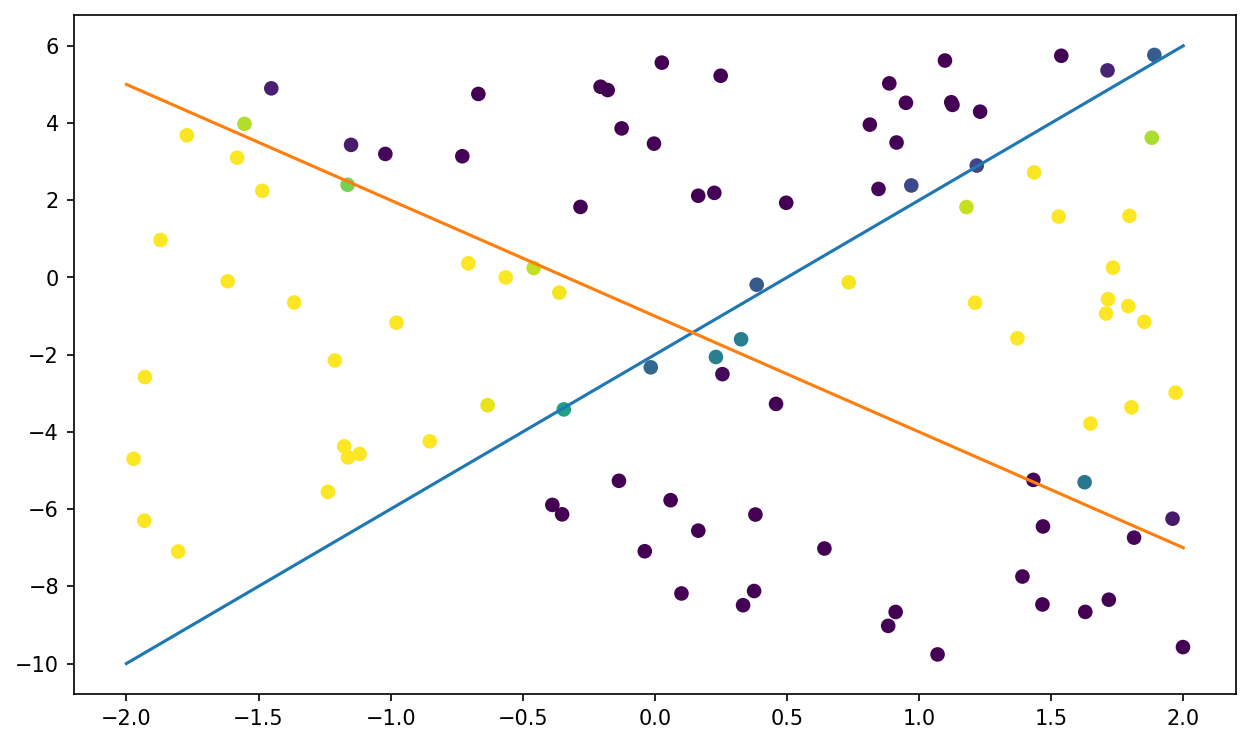

In [22]:
plt.figure(figsize=(10, 6), dpi=150)
plt.scatter(x='x', y='y', c='g_hat', data=df)
plt.plot(x, f1(x))
plt.plot(x, f2(x))
plt.savefig("all_adam_1e-4.png")
plt.show()